In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from itables import show
sns.set_style('darkgrid')

<IPython.core.display.Javascript object>

# Read datasets

In [3]:
data_campaign = pd.read_csv('anonymized_data/campaign_data.csv',)
data_coupon_to_item = pd.read_csv('anonymized_data/coupon_item_mapping.csv',)
data_demog = pd.read_csv('anonymized_data/customer_demographics.csv',)
data_transaction = pd.read_csv('anonymized_data/customer_transaction_data.csv',)
data_item = pd.read_csv("anonymized_data/item_data.csv")
data_train = pd.read_csv("anonymized_data/train.csv")
data_test = pd.read_csv("anonymized_data/test.csv")

# Simple Feature Set
- all customer demographics
- Transaction related: average customer spend, item count, unique item count
- Campaign related: type, length
- Coupon & Item related: brand, brand type, category counts by customer, coupon discount stats

## Demographics

In [4]:
# number of children
data_demog["no_of_children"] = data_demog["no_of_children"].fillna(0)

# encode age range, family size
dict_le = {}
for col in ["age_range", "family_size", "no_of_children"]:
    le = LabelEncoder()
    data_demog[col] = le.fit_transform(data_demog[col].apply(str))
    dict_le[col] = le

In [5]:
# marital status
data_demog = data_demog.join(pd.get_dummies(data_demog["marital_status"], prefix="marital_status"))
data_demog = data_demog.drop(columns=["marital_status"])

In [6]:
for col in data_demog.columns.drop('customer_id'):
    print(data_demog[col].value_counts(dropna=False))

3    271
2    187
1    130
5     68
4     59
0     45
Name: age_range, dtype: int64
0    719
1     41
Name: rented, dtype: int64
1    303
0    248
2    104
4     57
3     48
Name: family_size, dtype: int64
0    538
1    107
3     60
2     55
Name: no_of_children, dtype: int64
5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
12     10
10     10
11      5
Name: income_bracket, dtype: int64
0    443
1    317
Name: marital_status_Married, dtype: int64
0    646
1    114
Name: marital_status_Single, dtype: int64


In [7]:
for col in data_demog.columns.drop('customer_id'):
    data_demog[col] = data_demog[col].astype(np.int64)

## Transaction related
average customer spend, unique item count (per customer)

In [8]:
feat_ave_spend = data_transaction.groupby("customer_id")["selling_price"].mean().to_frame("customer_ave_spend")
feat_unique_items = data_transaction.groupby("customer_id")["item_id"].agg([("customer_unique_items", pd.Series.nunique)])
feat_transaction = feat_ave_spend.join(feat_unique_items, how='outer')

## Campaign Related
type, length (by campaign)

In [9]:
data_campaign["start_date"] = pd.to_datetime(data_campaign["start_date"], format='%d/%m/%y')
data_campaign["end_date"] = pd.to_datetime(data_campaign["end_date"], format='%d/%m/%y')
days_length = (data_campaign["end_date"] - data_campaign["start_date"]).dt.days

data_campaign["days_length"] = days_length
feat_campaign_length = data_campaign["days_length"]
feat_campaign_type_dummies = pd.get_dummies(data_campaign["campaign_type"], prefix="campaign_type")

In [10]:
feat_campaigns = feat_campaign_type_dummies.join(feat_campaign_length).join(data_campaign["campaign_id"])

## Item related
unique brand, brand type, category counts by customer

In [11]:
# brand, brand type, category
customer_to_item_coupon_merged = data_train.merge(data_coupon_to_item, how='left')\
                                            .merge(data_item, on = "item_id", how='left')

In [12]:
brand_counts = customer_to_item_coupon_merged.groupby("customer_id")["brand"].nunique().to_frame("brand_counts")
brand_type_counts = customer_to_item_coupon_merged.groupby(["customer_id", "brand_type"]).size().unstack().fillna(0)
brand_type_counts.columns = "brand_type_" + brand_type_counts.columns
category_type_counts = customer_to_item_coupon_merged.groupby(["customer_id", "category"]).size().unstack().fillna(0)
category_type_counts.columns = "category_type_" + category_type_counts.columns

feat_item = brand_counts.join(brand_type_counts).join(category_type_counts)

## Coupon Related
coupon discount stats, coupon item inclusions and categories

In [13]:
# merge train coupons to items to transactions to get discount
coupon_to_discount = data_coupon_to_item[data_coupon_to_item["coupon_id"].isin(data_train["coupon_id"])]\
                                                        .merge(data_item, on = "item_id", how='left')\
                                                        .merge(data_transaction[["item_id", "other_discount", "coupon_discount"]], on = "item_id", how='left')

In [14]:
show(coupon_to_discount.head())

,coupon_id,item_id,brand,brand_type,category,other_discount,coupon_discount


In [15]:
# coupon's item brand types and categories
# feat_item = brand_counts.join(brand_type_counts).join(category_type_counts)

coupon_brand_counts = coupon_to_discount.groupby("coupon_id")["brand"].nunique().to_frame("coupon_brand_counts")
coupon_brand_type_counts = coupon_to_discount.groupby(["coupon_id", "brand_type"]).size().unstack().fillna(0)
coupon_brand_type_counts.columns = "coupon_brand_type_" + coupon_brand_type_counts.columns

coupon_category_type_counts = coupon_to_discount.groupby(["coupon_id", "category"]).size().unstack().fillna(0)
coupon_category_type_counts.columns = "coupon_category_type_" + coupon_category_type_counts.columns

feat_coupon_item = coupon_brand_counts.join(coupon_brand_type_counts).join(coupon_category_type_counts)

In [16]:
feat_item_inclusions = coupon_to_discount.groupby("coupon_id")["item_id"].nunique().to_frame("number_of_coupon_items")
feat_other_discount_stats = coupon_to_discount.groupby("coupon_id")["other_discount"].agg(["mean", "min",])
feat_other_discount_stats.columns = "other_discount_stats_" + feat_other_discount_stats.columns

feat_coupon_discount_stats = coupon_to_discount.groupby("coupon_id")["coupon_discount"].agg(["mean", "min",])
feat_coupon_discount_stats.columns = "coupon_discount_stats_" + feat_coupon_discount_stats.columns

feat_coupon = feat_coupon_discount_stats.join(feat_other_discount_stats, how='left')

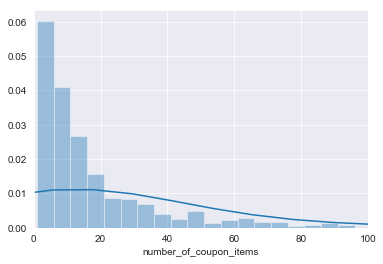

In [17]:
ax = sns.distplot(feat_item_inclusions["number_of_coupon_items"].clip(upper=1000), bins=200)

ax.set_xlim(0, 100);

# Popularity Features - Coupon, Campaign, Customer Triplets

In [18]:
def get_popularity_feature(id_to_index, name_of_feature):
    vc = data_train.groupby(id_to_index)["redemption_status"].value_counts().unstack()
    num_times_redeemed = vc.loc[:, 1].fillna(0)

    vc_pct = vc.div(vc.sum(axis=1), axis=0)
    pct_times_redeemed = vc_pct.loc[:, 1].fillna(0)
    
    name_1 = "num_{}_redeemed".format(name_of_feature)
    name_2 = "pct_{}_redeemed".format(name_of_feature)
    
    return num_times_redeemed.to_frame(name_1).join(pct_times_redeemed.to_frame(name_2))

In [19]:
feat_popularity_coupon = get_popularity_feature("coupon_id", "coupon").reset_index()
feat_popularity_campaign = get_popularity_feature("campaign_id", "campaign").reset_index()
feat_popularity_customer = get_popularity_feature("customer_id", "customer").reset_index()

# Join all features in train set

In [20]:
## demographics
# impute via mode
from sklearn.impute import SimpleImputer
demog_imputer = SimpleImputer(strategy="most_frequent")

data_train_demog = data_train.merge(feat_popularity_coupon)\
                .merge(feat_popularity_campaign).merge(feat_popularity_customer)\
                .merge(data_demog, how='left')
data_train_demog = pd.DataFrame(demog_imputer.fit_transform(data_train_demog), columns=data_train_demog.columns)

In [21]:
## transaction
data_merged = data_train_demog.merge(feat_transaction.reset_index(), how='left')

## campaign
data_merged = data_merged.merge(feat_campaigns, how='left')

## item
data_merged = data_merged.merge(feat_item.reset_index(), how='left')

## coupon
data_merged = data_merged.merge(feat_coupon.reset_index(), how='left')

## coupon_to_item feat_coupon_item
data_merged = data_merged.merge(feat_coupon_item.reset_index(), how='left')

# Modeling

In [22]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, balanced_accuracy_score, classification_report, confusion_matrix, average_precision_score
from sklearn.pipeline import make_pipeline

In [23]:
index_cols = ["id", "campaign_id", "coupon_id", "customer_id"]
target_col = "redemption_status"
X = data_merged.drop(columns=index_cols + [target_col])
y = data_merged[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [24]:
y.value_counts()

0.0    75041
1.0     2116
Name: redemption_status, dtype: int64

In [25]:
scoring_metrics = ['roc_auc', 'neg_log_loss', 'balanced_accuracy', 'average_precision']
# todo, the cross validate function only uses the predict function and not the predict -proba
def testing_suite(estimator, X_train, y_train, X_test, y_test, scoring_metrics = scoring_metrics):
    test_scores = cross_validate(estimator, X_train, y_train, scoring=scoring_metrics, cv=5)
    display(pd.DataFrame(test_scores))
        
    estimator.fit(X, y)
    
    print(classification_report(y_test, estimator.predict(X_test)))
    print("Log loss:", log_loss(y_test, estimator.predict_proba(X_test)))
    print("ROC:", roc_auc_score(y_test, estimator.predict_proba(X_test)[:, 1]))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, estimator.predict(X_test)))
    print("Average Precision:", average_precision_score(y_test, estimator.predict_proba(X_test)[:,1]))
    
    display(pd.DataFrame(confusion_matrix(y_test, estimator.predict(X_test)), index=["True0", "True1"], columns=["Prediction0", "Prediction1"]))
    
    return estimator

## Dummy Classifier, always 0

In [26]:
from sklearn.dummy import DummyClassifier
dummy_estimator = DummyClassifier(strategy='constant', constant=0)
dummy_estimator.fit(X_train, y_train)

print(classification_report(y_test, dummy_estimator.predict(X_test)))
print("Log loss:", log_loss(y_test, dummy_estimator.predict_proba(X_test)))
print("ROC:", roc_auc_score(y_test, dummy_estimator.predict_proba(X_test)[:, 1]))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, dummy_estimator.predict(X_test)))
print("Average Precision:", average_precision_score(y_test, dummy_estimator.predict_proba(X_test)[:, 1]))

display(pd.DataFrame(confusion_matrix(y_test, dummy_estimator.predict(X_test)), index=["True0", "True1"], columns=["Prediction0", "Prediction1"]))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     15009
         1.0       0.00      0.00      0.00       423

   micro avg       0.97      0.97      0.97     15432
   macro avg       0.49      0.50      0.49     15432
weighted avg       0.95      0.97      0.96     15432

Log loss: 0.9467277355525682
ROC: 0.5
Balanced Accuracy: 0.5
Average Precision: 0.027410575427682736


C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Prediction0,Prediction1
True0,15009,0
True1,423,0


## Random Guessing

In [27]:
dummy_estimator = DummyClassifier(strategy='uniform')
dummy_estimator.fit(X_train, y_train)

print(classification_report(y_test, dummy_estimator.predict(X_test)))
print("Log loss:", log_loss(y_test, dummy_estimator.predict_proba(X_test)))
print("ROC:", roc_auc_score(y_test, dummy_estimator.predict_proba(X_test)[:, 1]))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, dummy_estimator.predict(X_test)))
print("Average Precision:", average_precision_score(y_test, dummy_estimator.predict_proba(X_test)[:, 1]))

display(pd.DataFrame(confusion_matrix(y_test, dummy_estimator.predict(X_test)), index=["True0", "True1"], columns=["Prediction0", "Prediction1"]))

              precision    recall  f1-score   support

         0.0       0.97      0.50      0.66     15009
         1.0       0.03      0.48      0.05       423

   micro avg       0.50      0.50      0.50     15432
   macro avg       0.50      0.49      0.36     15432
weighted avg       0.95      0.50      0.65     15432

Log loss: 0.6931471805599452
ROC: 0.5
Balanced Accuracy: 0.494730821081819
Average Precision: 0.027410575427682736


,Prediction0,Prediction1
True0,7561,7448
True1,213,210


## Logistic Regression

C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\valeridm\AppData\Roaming\Python\P

C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklea

,fit_time,score_time,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_balanced_accuracy,train_balanced_accuracy,test_average_precision,train_average_precision
0,3.046993,0.084000,0.965143,0.963810,-0.121356,-0.124462,0.860116,0.865428,0.606197,0.597249
1,3.661998,0.093001,0.965476,0.963435,-0.126428,-0.124874,0.881990,0.863170,0.593800,0.597307
2,3.736993,0.082000,0.961222,0.965191,-0.127963,-0.124321,0.854315,0.865033,0.576564,0.599414
3,3.641990,0.085000,0.958664,0.964528,-0.124887,-0.123394,0.861082,0.867096,0.590066,0.603945
4,3.829997,0.211004,0.957090,0.965648,-0.126342,-0.124176,0.858123,0.867184,0.597232,0.599136


C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\valeridm\AppData\Roaming\Python\P

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     15009
         1.0       0.39      0.79      0.52       423

   micro avg       0.96      0.96      0.96     15432
   macro avg       0.69      0.88      0.75     15432
weighted avg       0.98      0.96      0.97     15432

Log loss: 0.12335862735848617
ROC: 0.9624920083410945
Balanced Accuracy: 0.8763607083976565
Average Precision: 0.6356329357886312


C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,Prediction0,Prediction1
True0,14491,518
True1,90,333


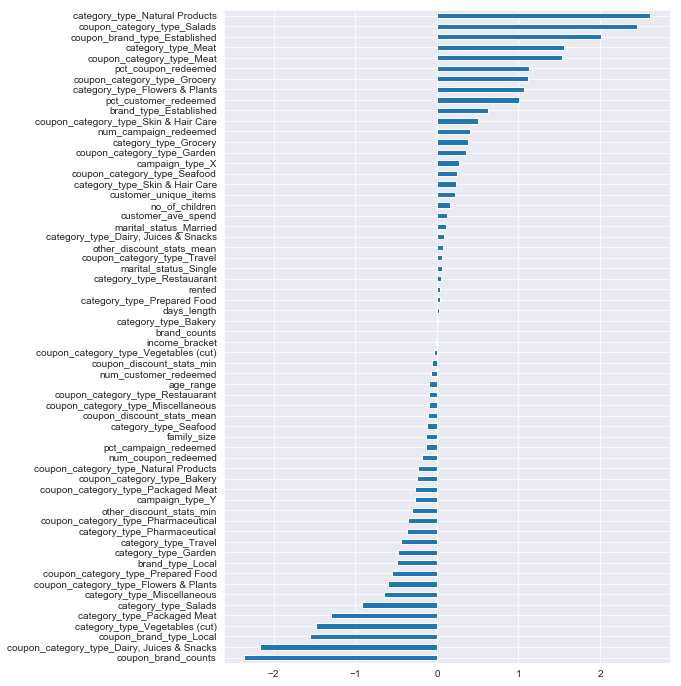

In [28]:
lr = LogisticRegression(solver = 'lbfgs', max_iter=300, class_weight={0 : 1, 1 : 10})
pipeline = make_pipeline(StandardScaler(), lr)

pipeline = testing_suite(pipeline, X_train, y_train, X_test, y_test)
series_coef = pd.Series(pipeline.steps[1][1].coef_.ravel(), index=X_train.columns,).sort_values()
plt.figure(figsize=(8, 12))
top_coef = series_coef[abs(series_coef) > 1e-4]
top_coef.plot.barh()

## GradientBoostedTrees
- "fast hyperparameters", no optimization

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier(verbose=1, subsample=0.8, )
gbt = testing_suite(gbt, X_train, y_train, X_test, y_test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1763           0.0745           13.27s
         2           0.1617           0.0128           15.83s
         3           0.1524           0.0095           18.37s
         4           0.1443           0.0081           17.76s
         5           0.1381           0.0068           17.88s
         6           0.1324           0.0056           16.81s
         7           0.1256           0.0051           16.37s
         8           0.1202           0.0043           15.79s
         9           0.1180           0.0032           15.48s
        10           0.1127           0.0032           14.95s
        20           0.0959           0.0009           12.64s
        30           0.0873           0.0001           10.51s
        40           0.0820           0.0002            9.17s
        50           0.0807          -0.0000            7.50s
        60           0.0764          -0.0001            5.89s
       

C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_roc_auc'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_log_loss'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\valeridm\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_balanced_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

,fit_time,score_time,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_balanced_accuracy,train_balanced_accuracy,test_average_precision,train_average_precision
0,13.858998,0.166034,0.986711,0.990294,-0.042712,-0.036071,0.808877,0.821903,0.758887,0.826592
1,14.902970,0.258005,0.989214,0.989933,-0.038864,-0.037032,0.800361,0.807533,0.796823,0.817498
2,14.446976,0.132996,0.987263,0.990071,-0.040630,-0.036832,0.806136,0.818944,0.784220,0.818850
3,17.445991,0.669004,0.985903,0.990572,-0.042977,-0.035861,0.783421,0.822226,0.758787,0.827903
4,14.592021,0.159003,0.985887,0.990382,-0.043463,-0.036440,0.800631,0.813905,0.752410,0.821538


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1745           0.0814           17.13s
         2           0.1632           0.0132           18.08s
         3           0.1528           0.0103           17.98s
         4           0.1467           0.0073           18.77s
         5           0.1371           0.0066           19.23s
         6           0.1321           0.0056           18.78s
         7           0.1281           0.0052           18.33s
         8           0.1227           0.0041           18.25s
         9           0.1209           0.0034           18.00s
        10           0.1160           0.0026           18.06s
        20           0.0966           0.0007           16.03s
        30           0.0902           0.0001           13.62s
        40           0.0869           0.0003           11.66s
        50           0.0835          -0.0000            9.55s
        60           0.0807           0.0001            7.55s
       

,Prediction0,Prediction1
True0,14959,50
True1,145,278


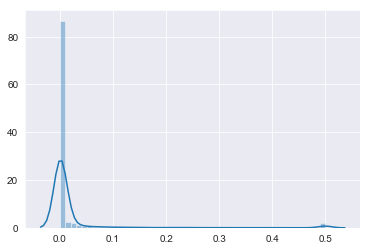

In [30]:
ax = sns.distplot(pd.Series(gbt.predict_proba(X_test)[:, 1]).clip(upper=0.5))

In [31]:
y_preds = np.where(gbt.predict_proba(X_test)[:, 1] > 0.3, 1, 0)
print(classification_report(y_test, y_preds))
print("Log loss:", log_loss(y_test, gbt.predict_proba(X_test)))
print("ROC:", roc_auc_score(y_test, gbt.predict_proba(X_test)[:, 1]))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_preds))
print("Average Precision:", average_precision_score(y_test, gbt.predict_proba(X_test)[:, 1]))

display(pd.DataFrame(confusion_matrix(y_test, y_preds), index=["True0", "True1"], columns=["Prediction0", "Prediction1"]))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     15009
         1.0       0.70      0.76      0.73       423

   micro avg       0.98      0.98      0.98     15432
   macro avg       0.85      0.87      0.86     15432
weighted avg       0.99      0.98      0.98     15432

Log loss: 0.037960231919819086
ROC: 0.9884296372531092
Balanced Accuracy: 0.8737199760521938
Average Precision: 0.8104348542145476


,Prediction0,Prediction1
True0,14873,136
True1,103,320


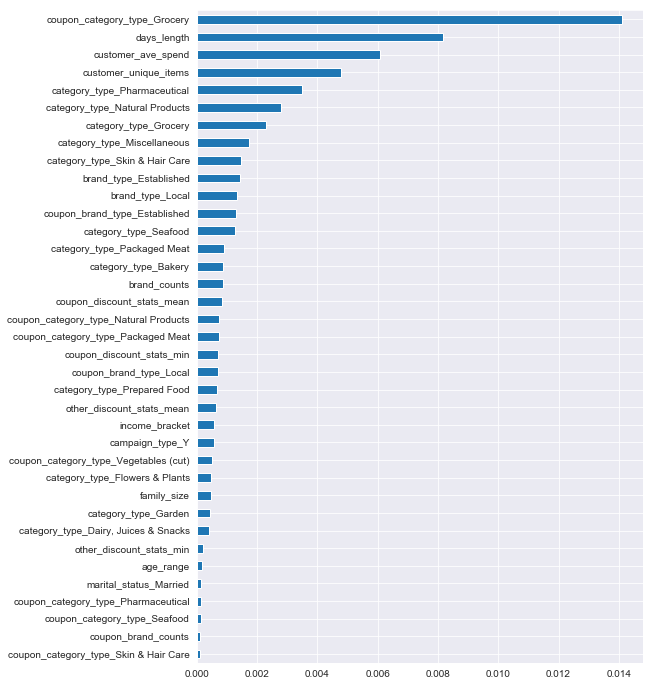

In [37]:
series_coef = pd.Series(gbt.feature_importances_.ravel(), index=X_train.columns,).sort_values()
# removing the popularity features since they account for 90+ % of the strength of the model
series_coef = series_coef.drop(series_coef.filter(like="redeemed").index)
plt.figure(figsize=(8, 12))
top_coef = series_coef[abs(series_coef) > 1e-4]
top_coef.plot.barh()

## RandomForest
hyperparameter-optimization commented out

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose=1)

# param_grid = {"class_weight" : [{0 : 1, 1:100}, {0 : 1, 1:1000}, 'balanced', 'balanced_subsample'],
#               "max_depth" : [10, 20], "min_samples_leaf" : [1e-3, 1e-4], 
#               "n_estimators" : [10, 20, ]}

param_grid = {"class_weight" : ['balanced_subsample'],
              "max_depth" : [10, 20], "min_samples_leaf" : [1e-3, 1e-4], 
              "n_estimators" : [10, 20, ]}
grid_search = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=5, n_jobs=2, verbose=1)
grid_search.fit(X_train, y_train)

rf = grid_search.best_estimator_
rf = testing_suite(rf, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:   35.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=

,fit_time,score_time,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_balanced_accuracy,train_balanced_accuracy,test_average_precision,train_average_precision
0,1.066001,0.174994,0.986037,0.991455,-0.123392,-0.121613,0.924534,0.960996,0.758141,0.800434
1,1.131003,0.186000,0.987514,0.991282,-0.121936,-0.124693,0.941008,0.960552,0.777150,0.801546
2,0.957004,0.149028,0.986728,0.991333,-0.128096,-0.122650,0.940641,0.959168,0.779034,0.808642
3,1.107001,0.147995,0.986022,0.991959,-0.117551,-0.117389,0.937635,0.961404,0.755136,0.816193
4,0.947997,0.173004,0.985006,0.991873,-0.129377,-0.120463,0.932803,0.963842,0.739908,0.814411


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     15009
         1.0       0.30      0.97      0.46       423

   micro avg       0.94      0.94      0.94     15432
   macro avg       0.65      0.95      0.71     15432
weighted avg       0.98      0.94      0.95     15432

Log loss: 0.1411822506025804


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ROC: 0.9896701852804786


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


Balanced Accuracy: 0.9517039185472168
Average Precision: 0.7931263097019341


,Prediction0,Prediction1
True0,14056,953
True1,14,409


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


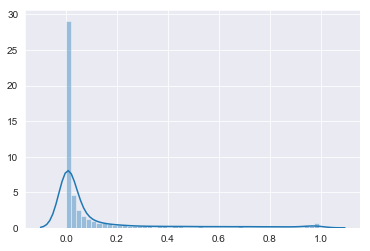

In [39]:
ax = sns.distplot(pd.Series(rf.predict_proba(X_test)[:, 1]))

In [40]:
y_preds = np.where(rf.predict_proba(X_test)[:, 1] > 0.5, 1, 0)
print(classification_report(y_test, y_preds))
print("Log loss:", log_loss(y_test, rf.predict_proba(X_test)))
print("ROC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_preds))
print("Average Precision:", average_precision_score(y_test, rf.predict_proba(X_test)[:, 1]))

display(pd.DataFrame(confusion_matrix(y_test, y_preds), index=["True0", "True1"], columns=["Prediction0", "Prediction1"]))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     15009
         1.0       0.30      0.97      0.46       423

   micro avg       0.94      0.94      0.94     15432
   macro avg       0.65      0.95      0.71     15432
weighted avg       0.98      0.94      0.95     15432

Log loss: 0.1411822506025804


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ROC: 0.9896701852804786
Balanced Accuracy: 0.9517039185472168
Average Precision: 0.7931263097019341


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


,Prediction0,Prediction1
True0,14056,953
True1,14,409


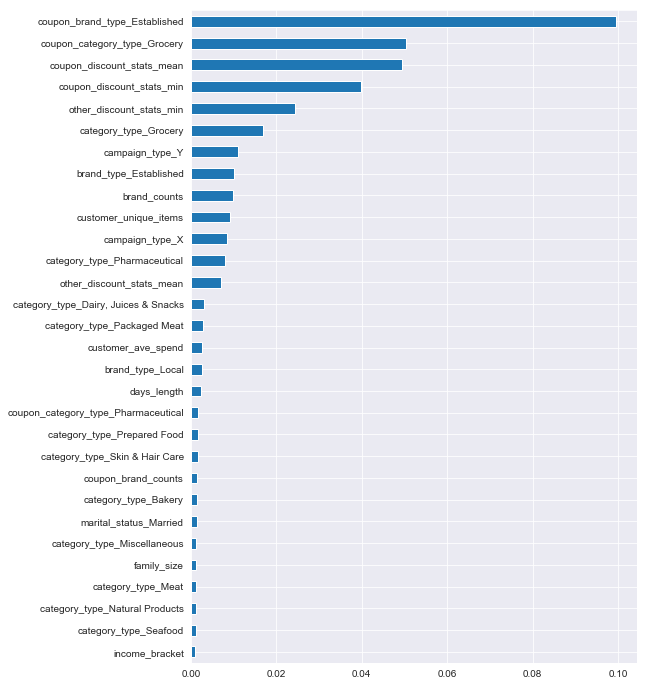

In [43]:
series_coef = pd.Series(rf.feature_importances_.ravel(), index=X_train.columns,).sort_values()
# removing the popularity features since they account for 90+ % of the strength of the model
series_coef = series_coef.drop(series_coef.filter(like="redeemed").index)
plt.figure(figsize=(8, 12))
top_coef = series_coef[abs(series_coef) > 1e-3]
top_coef.plot.barh()

# Apply to Test

In [52]:
# brand, brand type, category
customer_to_item_coupon_merged = data_test.merge(data_coupon_to_item, how='left')\
                                            .merge(data_item, on = "item_id", how='left')

In [46]:
brand_counts = customer_to_item_coupon_merged.groupby("customer_id")["brand"].nunique().to_frame("brand_counts")
brand_type_counts = customer_to_item_coupon_merged.groupby(["customer_id", "brand_type"]).size().unstack().fillna(0)
brand_type_counts.columns = "brand_type_" + brand_type_counts.columns
category_type_counts = customer_to_item_coupon_merged.groupby(["customer_id", "category"]).size().unstack().fillna(0)
category_type_counts.columns = "category_type_" + category_type_counts.columns

feat_item = brand_counts.join(brand_type_counts).join(category_type_counts)

In [47]:
# merge train coupons to items to transactions to get discount
coupon_to_discount = data_coupon_to_item[data_coupon_to_item["coupon_id"].isin(data_test["coupon_id"])]\
                                                        .merge(data_item, on = "item_id", how='left')\
                                                        .merge(data_transaction[["item_id", "other_discount", "coupon_discount"]], on = "item_id", how='left')

In [48]:
# coupon's item brand types and categories
# feat_item = brand_counts.join(brand_type_counts).join(category_type_counts)

coupon_brand_counts = coupon_to_discount.groupby("coupon_id")["brand"].nunique().to_frame("coupon_brand_counts")
coupon_brand_type_counts = coupon_to_discount.groupby(["coupon_id", "brand_type"]).size().unstack().fillna(0)
coupon_brand_type_counts.columns = "coupon_brand_type_" + coupon_brand_type_counts.columns

coupon_category_type_counts = coupon_to_discount.groupby(["coupon_id", "category"]).size().unstack().fillna(0)
coupon_category_type_counts.columns = "coupon_category_type_" + coupon_category_type_counts.columns

feat_coupon_item = coupon_brand_counts.join(coupon_brand_type_counts).join(coupon_category_type_counts)

In [49]:
feat_item_inclusions = coupon_to_discount.groupby("coupon_id")["item_id"].nunique().to_frame("number_of_coupon_items")
feat_other_discount_stats = coupon_to_discount.groupby("coupon_id")["other_discount"].agg(["mean", "min",])
feat_other_discount_stats.columns = "other_discount_stats_" + feat_other_discount_stats.columns

feat_coupon_discount_stats = coupon_to_discount.groupby("coupon_id")["coupon_discount"].agg(["mean", "min",])
feat_coupon_discount_stats.columns = "coupon_discount_stats_" + feat_coupon_discount_stats.columns

feat_coupon = feat_coupon_discount_stats.join(feat_other_discount_stats, how='left')

In [54]:
## test demographics first
# add a label column to enable imputation
data_test["redemption_status"] = 0

# impute via mode
data_test_demog = data_test.merge(feat_popularity_campaign).merge(feat_popularity_coupon)\
                                .merge(feat_popularity_customer).merge(data_demog, how='left')
data_test_demog = pd.DataFrame(demog_imputer.transform(data_test_demog), columns=data_test_demog.columns)

In [55]:
## transaction
data_test_merged = data_test_demog.merge(feat_transaction.reset_index(), how='left')

## campaign
data_test_merged = data_test_merged.merge(feat_campaigns, how='left')

## item
data_test_merged = data_test_merged.merge(feat_item.reset_index(), how='left')

## coupon
data_test_merged = data_test_merged.merge(feat_coupon.reset_index(), how='left')

## coupon_to_item feat_coupon_item
data_test_merged = data_test_merged.merge(feat_coupon_item.reset_index(), how='left')

In [56]:
# same order as training columns
data_test_merged = data_test_merged[data_merged.columns]

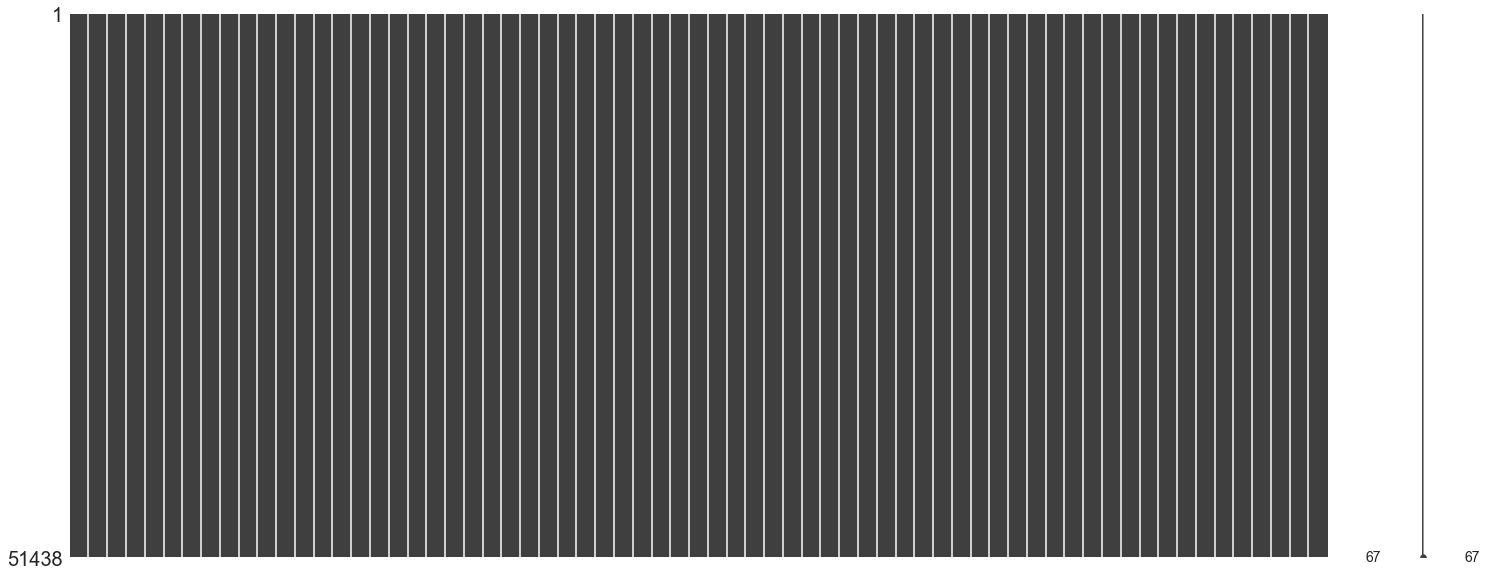

In [57]:
import missingno as msno
msno.matrix(data_test_merged)

In [58]:
X_to_predict = data_test_merged.drop(columns=index_cols + [target_col])
index_to_predict = data_test_merged[index_cols]

In [59]:
X_train.shape, X_to_predict.shape

((61725, 62), (51438, 62))

In [60]:
# align columns and fill to 0
missing_cols = set(X_train.columns).difference(set(X_to_predict.columns))
print("Columns not found in prediction set:", missing_cols)

for c in missing_cols:
    X_to_predict.loc[:,c] = 0

X_to_predict = X_to_predict[X_train.columns]

Columns not found in prediction set: set()


In [61]:
X_train.shape, X_to_predict.shape

((61725, 62), (51438, 62))

In [62]:
y_to_predict_proba = pd.Series(rf.predict_proba(X_to_predict)[:,1])
y_to_predict_preds = pd.Series(np.where(y_to_predict_proba > 0.2, 1, 0))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


0    43958
1     7480
dtype: int64

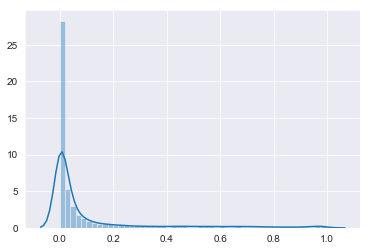

In [63]:
sns.distplot(y_to_predict_proba)
y_to_predict_preds.value_counts()

In [64]:
data_test_additional = index_to_predict[["id"]].join(y_to_predict_proba.to_frame("redemption_status"))
data_test_additional["id"] = data_test_additional["id"].astype(np.int64)
data_test_additional.to_csv("dylan-submission.csv", index=False)

In [51]:
sample_solution = data_test_additional[["id"]].copy()
sample_solution["redemption_status"] = np.random.uniform(size=len(data_test_additional))

# sample solutions file
sample_solution.to_csv("anonymized_data/sample-solution.csv", index=False)
sample_solution

,id,redemption_status
0,78152.0,0.245974
1,12805.0,0.860074
2,51405.0,0.331146
3,86421.0,0.117892
4,125211.0,0.912843
...,...,...
51433,55793.0,0.024241
51434,37045.0,0.319084
51435,98025.0,0.979899
51436,45982.0,0.228859


# Bonus: Interaction Features

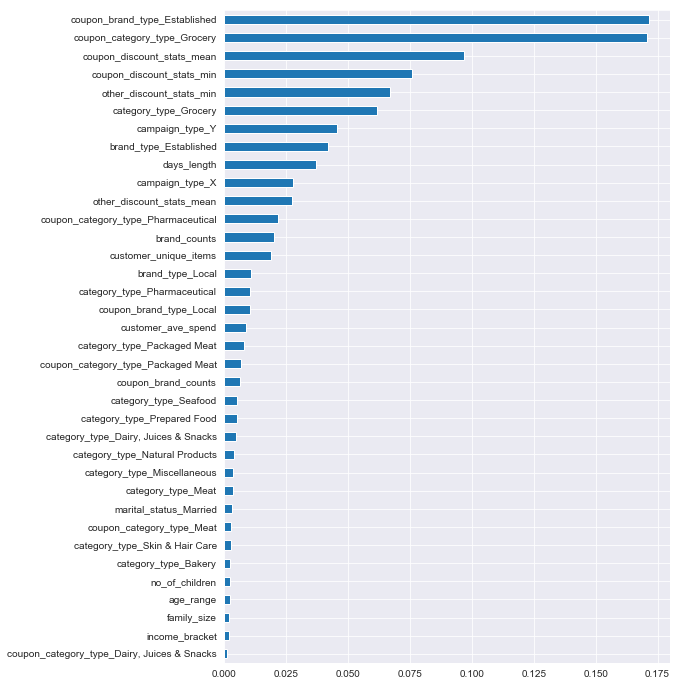

In [52]:
series_coef = pd.Series(rf.feature_importances_.ravel(), index=X_train.columns,).sort_values()
plt.figure(figsize=(8, 12))
top_coef = series_coef[abs(series_coef) > 1e-3]
top_coef.plot.barh()

In [53]:
X_train_established = X_train.filter(like="Established").copy()
Xy_train_established = X_train_established.join(y_train)

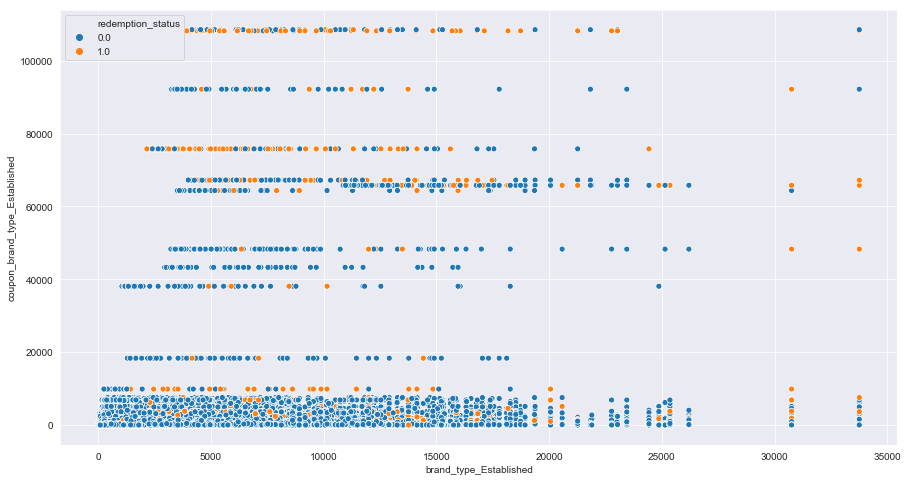

In [54]:
ax = plt.figure(figsize=(15,8)).add_subplot(111)
sns.scatterplot(x="brand_type_Established", y="coupon_brand_type_Established", 
                hue="redemption_status", data=Xy_train_established, ax=ax)

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced')

# shortcuts were made
scores = cross_val_score(dt, Xy_train_established.drop(columns=["redemption_status"]), 
                Xy_train_established["redemption_status"], scoring='roc_auc', cv=5)
print(scores)
dt.fit(Xy_train_established.drop(columns=["redemption_status"]), 
                Xy_train_established["redemption_status"]);

[0.89214711 0.9041874  0.91598191 0.89598039 0.89421401]


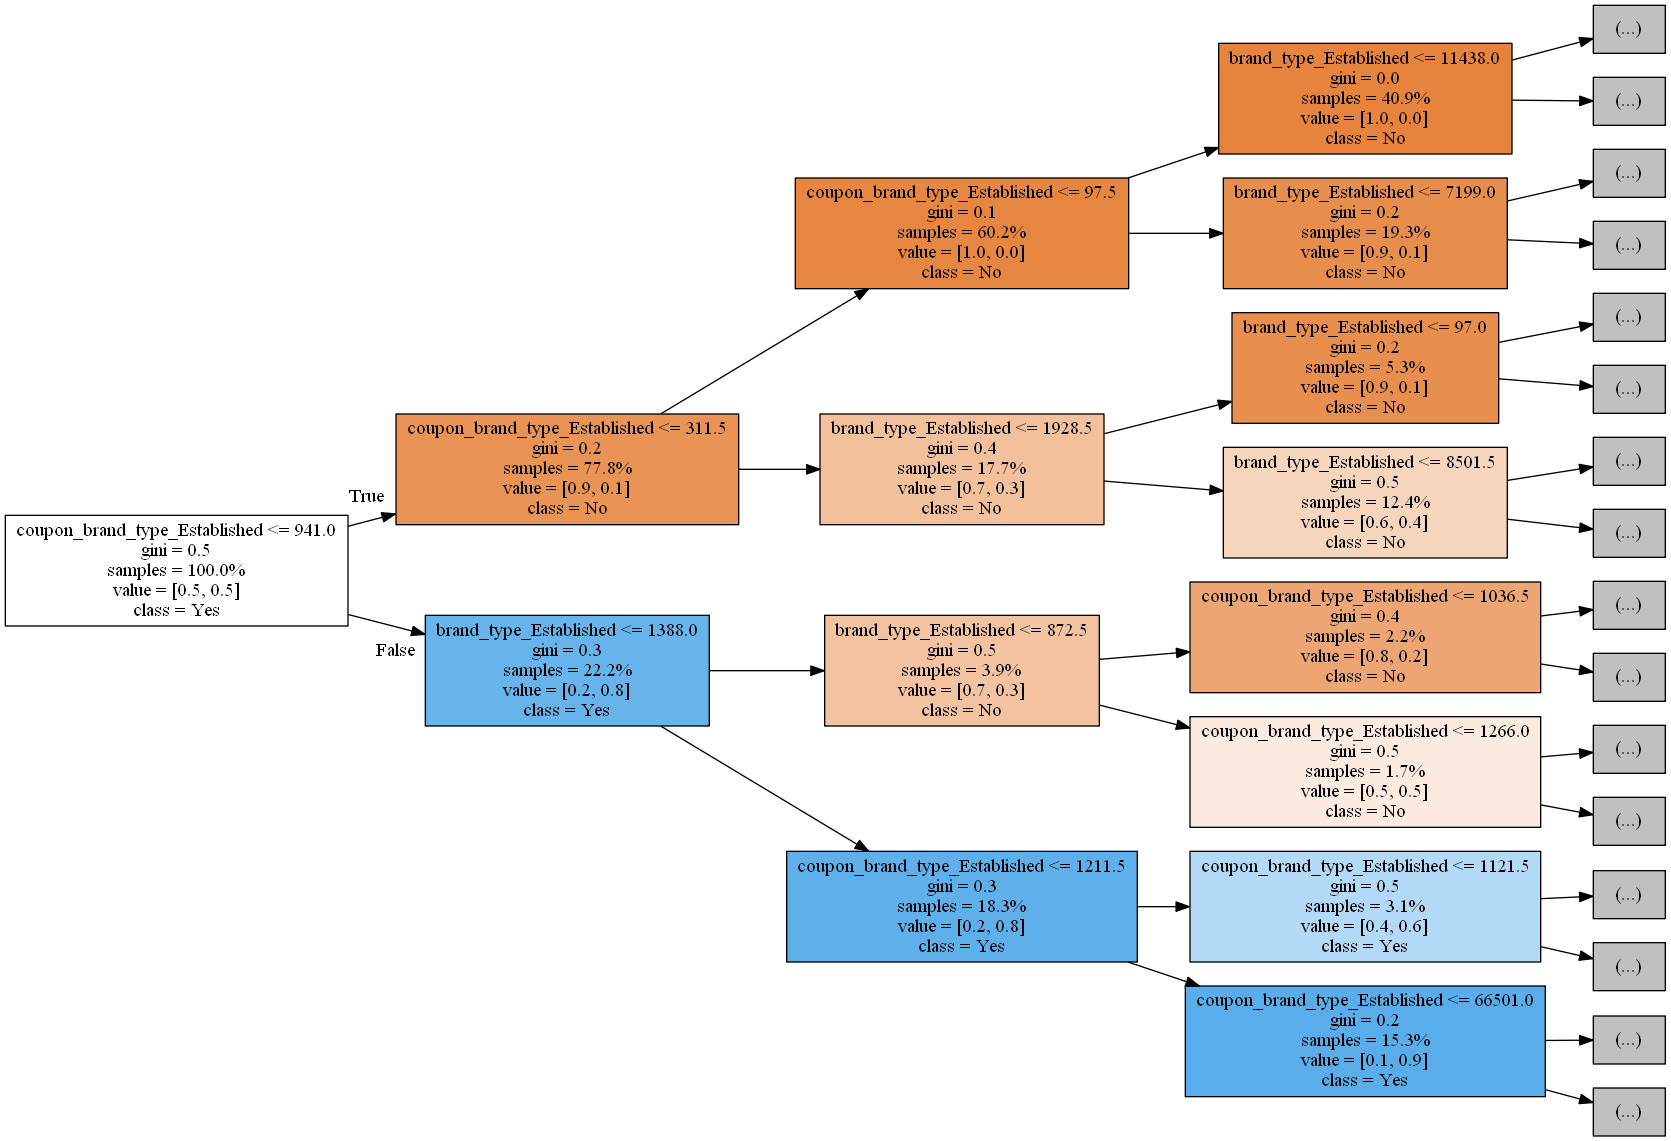

In [56]:
from sklearn import tree
import pydotplus
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=Xy_train_established.filter(like="brand").columns,  
                                class_names=["No", "Yes"], max_depth=3, filled=True, precision=1, proportion=True, rotate=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Another Example: Groceries

In [57]:
X_train_grocer = X_train.filter(like="Grocer").copy()
Xy_train_grocer = X_train_grocer.join(y_train)

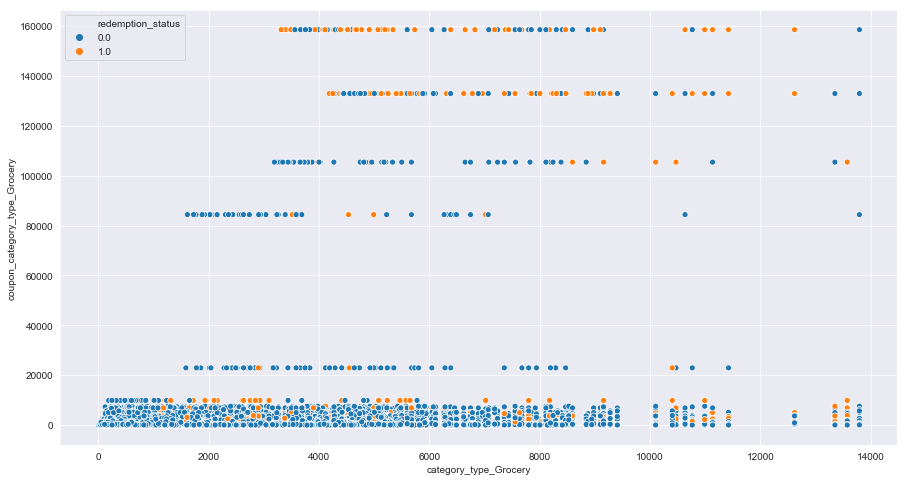

In [58]:
ax = plt.figure(figsize=(15,8)).add_subplot(111)
sns.scatterplot(x="category_type_Grocery", y="coupon_category_type_Grocery", 
                hue="redemption_status", data=Xy_train_grocer, ax=ax)

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced')

# shortcuts were made
scores = cross_val_score(dt, Xy_train_grocer.drop(columns=["redemption_status"]), 
                Xy_train_grocer["redemption_status"], scoring='roc_auc', cv=5)
print(scores)
dt.fit(Xy_train_grocer.drop(columns=["redemption_status"]), 
                Xy_train_grocer["redemption_status"]);

[0.83790097 0.86157731 0.88207519 0.86470929 0.8709675 ]


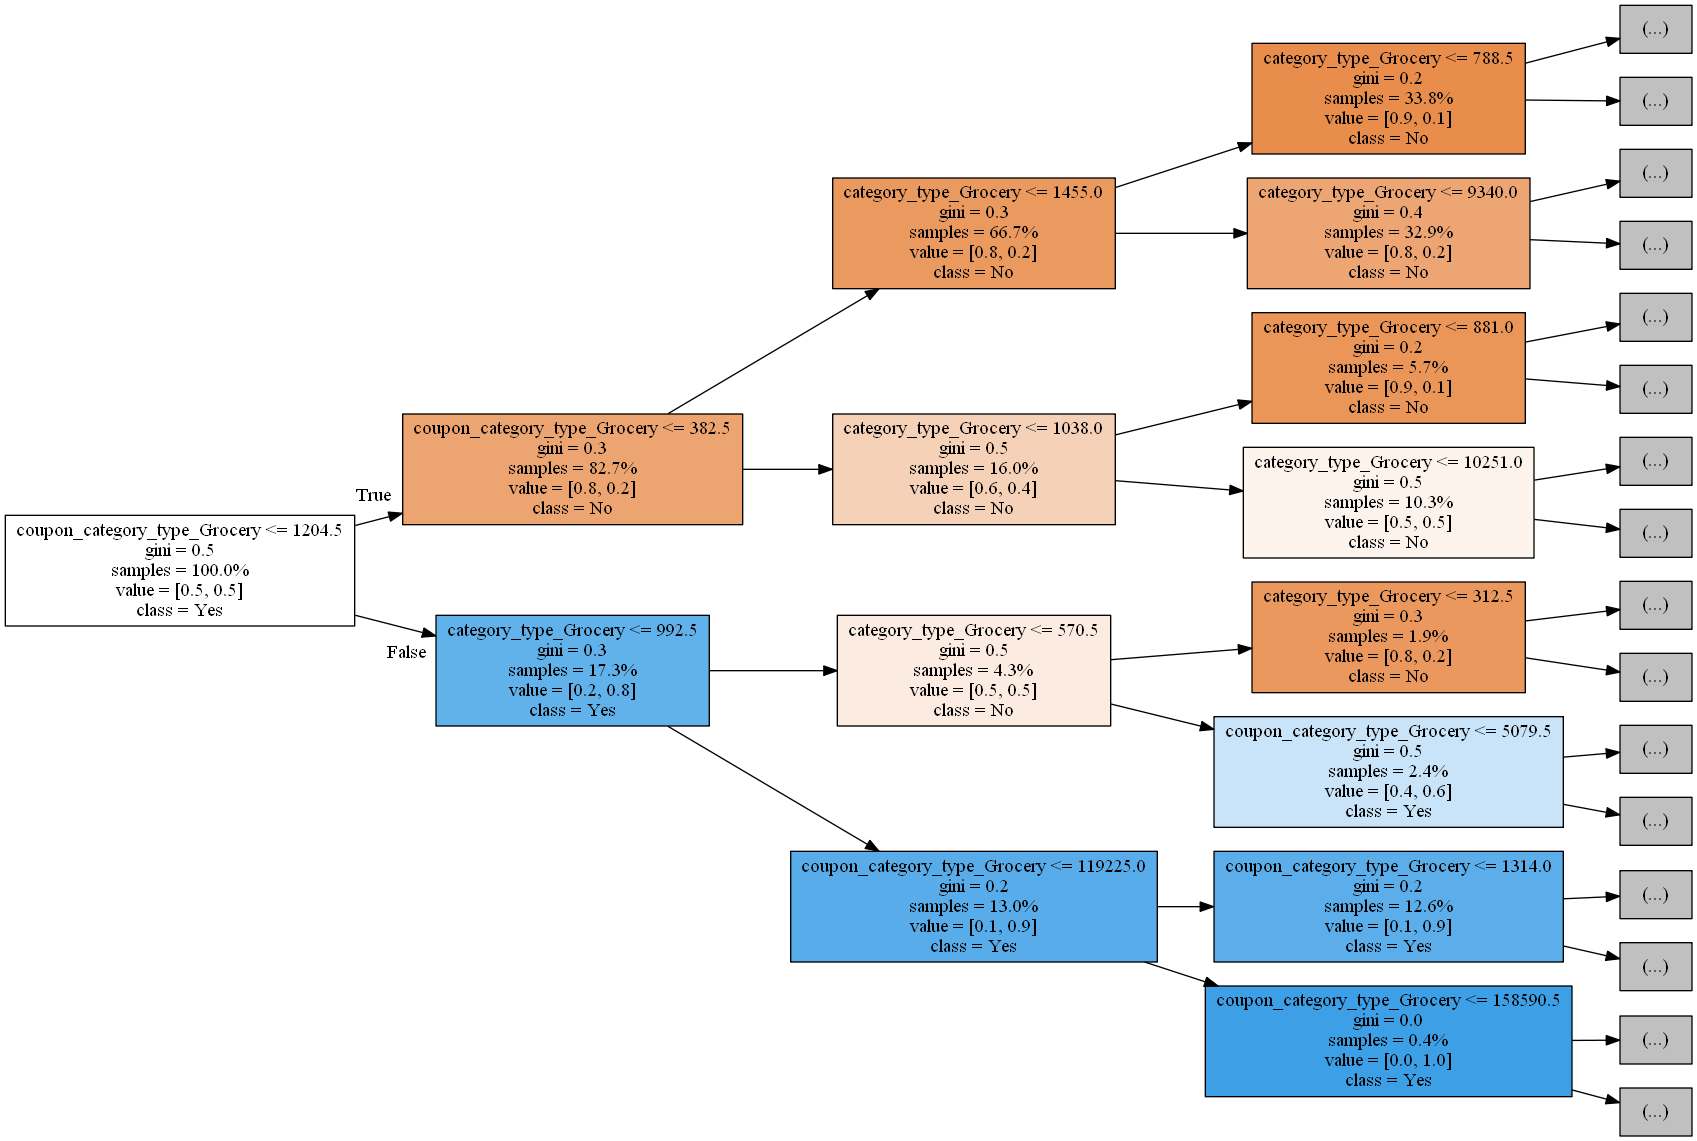

In [60]:
from sklearn import tree
import pydotplus
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=Xy_train_grocer.filter(like="Grocer").columns,  
                                class_names=["No", "Yes"], max_depth=3, filled=True, precision=1, proportion=True, rotate=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Tabulation of my own results (own test data)



# Other Methods
## Recommendation Systems
Recommendation systems predict would-be items for users.

Based on a user's history, a recommendation algorithm can predict the customer's future wants. Hence, we can pick the coupons that contains those items.

![RecSys](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR0-dUiQRRGwxv21flncZU_DaxfxBCcocKCyAsxR5cLCwvs4-PQ)

## Principal Components Analysis / Matrix Factorization
Summarize a person's buying history through matrix factorization and take the top factors.
![PCA](https://pubs.broadinstitute.org/mpr/projects/NMF/NMF_website2.gif)